In [6]:
import pandas as pd
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('train.csv')

In [8]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
df.shape

(159571, 8)

In [10]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
from tensorflow.keras.layers import TextVectorization
X = df['comment_text']
y = df[df.columns[2:]].values
MAX_FEATURES = 200000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X.values)

In [13]:
vectorized_text = vectorizer(X.values)
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [15]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                        

In [23]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 5117s 732ms/step - loss: 0.0725 - val_loss: 0.0523
Epoch 2/5
6981/6981 [==============================] - 4879s 699ms/step - loss: 0.0537 - val_loss: 0.0454
Epoch 3/5
6981/6981 [==============================] - 7014s 1s/step - loss: 0.0467 - val_loss: 0.0418
Epoch 4/5
6981/6981 [==============================] - 9807s 1s/step - loss: 0.0418 - val_loss: 0.0365
Epoch 5/5
6981/6981 [==============================] - 6561s 940ms/step - loss: 0.0370 - val_loss: 0.0320


In [25]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

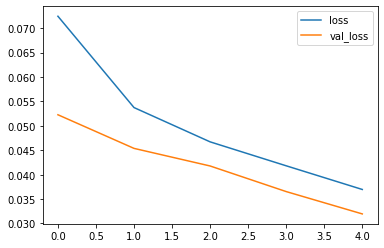

In [26]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [27]:
input_text = vectorizer('You freaking suck! I am going to hit you.')


In [49]:
res = model.predict(np.expand_dims(input_text,0))


1/1 [==============================] - 0s 106ms/step


In [50]:
res

array([[1.27036416e-03, 1.73589376e-09, 2.64843693e-04, 3.93124174e-06,
        2.35956220e-04, 1.14350314e-05],
       [2.61016830e-04, 6.18713206e-11, 7.14591442e-05, 4.78098457e-07,
        4.98247937e-05, 1.68802558e-06],
       [5.13289197e-05, 2.58527661e-12, 2.08156980e-05, 6.37361524e-08,
        1.09659268e-05, 2.77997231e-07],
       [1.13188602e-04, 8.94824406e-12, 3.30760377e-05, 1.44902202e-07,
        2.08886195e-05, 5.68709652e-07],
       [1.48303446e-03, 2.60623323e-09, 3.08462448e-04, 5.11126655e-06,
        2.82552704e-04, 1.44495125e-05],
       [5.09182990e-01, 1.08306867e-03, 8.82881805e-02, 7.96392374e-03,
        1.40245035e-01, 1.76972710e-02],
       [1.83204756e-04, 1.94691225e-11, 4.50605803e-05, 2.36053125e-07,
        3.10788164e-05, 8.85982899e-07],
       [6.30708746e-05, 1.70951339e-12, 1.71788051e-05, 5.17472003e-08,
        1.03684051e-05, 2.23367451e-07],
       [9.37176592e-05, 2.73941243e-12, 2.06236000e-05, 7.07309766e-08,
        1.38412925e-05, 

In [51]:
(res > 0.5).astype(int)
batch_X, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_X) > 0.5).astype(int)
res.shape

1/1 [==============================] - 0s 116ms/step


(16, 6)

In [24]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [25]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 220ms/step


1/1 [==============================] - 0s 217ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 258ms/step


In [26]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


Precision: 0.8629953265190125, Recall:0.7136906385421753, Accuracy:0.505516529083252


In [59]:
!pip install gradio jinja2



[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
model.save('TextModeration.h5')


In [4]:
import tensorflow as tf
import gradio as gr

In [16]:
input_str = vectorizer('hey i freaken hate you!')


In [17]:
model = tf.keras.models.load_model('Moderation.h5')


In [18]:
res = model.predict(np.expand_dims(input_str,0))


1/1 [==============================] - 2s 2s/step


In [19]:
res

array([[0.728046  , 0.00516159, 0.12854445, 0.02429421, 0.26189402,
        0.04450722]], dtype=float32)

In [27]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [28]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [29]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://5001023259e244b7.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x19d8945daf0>,
 'http://127.0.0.1:7861/',
 'https://5001023259e244b7.gradio.app')

1/1 [==============================] - 0s 186ms/step
